# Pump-probe, no delay, normalised reduction

Here, we show how to reduce raw data for pump-probe runs using normalised processing. For more details on normalised processing, please refer to static-normalised tuttorial.

We start by importing the modules we are going to use:

In [1]:
import numpy as np
import extra_data as ed
import extra_geom as eg
import toolbox_scs.detectors as tbdet
import euxfel_scs_tools as scs

In the following cell, we define run-specific information. Because dark run is a part of reduction, it has to be defined.

In [2]:
proposal = 2530  # proposal number
run = 99  # run number
dark_run = 100  # dark run
pattern = ['pumped', 'intradark1', 'unpumped', 'intradark2'] * 40  # the pattern of frames in each train
dirname = 'processed_runs_xgm'  # directory where we are going to save processed data

The length of `pattern` list must be the same as the number of frames per train. `dirname` can be any path, but in the case of reducing data, the resulting files cannot be written if you do not have writing priviledges in that directory. Accordingly, it is most safe to keep all files you process in your user directory.

Before we can run normalised reduction, we need to process dark run.

In [3]:
scs.reduction_std(proposal=proposal, run=dark_run, pattern=pattern, dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


## Data reduction

From the notebook `scs.reduction_norm` can be called. This function is going to submit 16 jobs to the queue (one per DSSC module). Function's signature is:

```
scs.reduction_norm(proposal,
                   run,
                   pattern,
                   dark_run,
                   frames={'image': 'image', 'dark': 'dark'},
                   dark_run_frames={'image': 'image', 'dark': 'dark'},
                   trains=None,
                   xgm_threshold=(1e-5, np.inf),
                   njobs=40,
                   dirname=None):
```

The individual arguments are:

- `proposal` - proposal number
- `run` - run number
- `pattern` - the pattern of frames in each train
- `dark_run` - dark run number
- `frames` - what frame type is considered to be "image" and what is considered to be "dark" in pattern. This is used for pump-probe reduction when frames can be called "pumped", "unpumped", etc. or when in pattern dark frames are called "intradark". This is like a lookup-table which allows generalisation independent of the naming of frames in `pattern`.
- `dark_run_frames` - similar to `frames`. More precisely, what is the name of image frame and dark frame.
- `trains` - the list of train indices whose frames are reduced. It defaults to `None` and all trains in the run will be summed.
- `xgm_threshold` - a tuple of min and max value. All frames with XGM outside that range will be ignored in reduction.
- `njobs` - the number of jobs executed on each node
- `dirname` - directory name where reduced files are going to be saved

The function call is, with selecting `frames` and `dark_run_frames` is:

In [4]:
scs.reduction_norm(proposal=proposal, run=run, pattern=pattern, dark_run=dark_run,
                   frames={'image': 'pumped', 'dark': 'intradark1'},
                   dark_run_frames={'image': 'pumped', 'dark': 'intradark1'},
                   xgm_threshold=(0.1, 0.5),
                   dirname=dirname)

Submitted 16 slurm jobs to the queue. Please wait for jobs to complete.


After some time (in my case 5 min), all jobs are completed and in `dirname` directory `run_98` is created. Inside that directory, 16 `.h5` files are created with names `module_NUM_norm.h5`, where `NUM` is the module number (0, 1, 2,... 15). In each HDF5 file, the following arrays are saved:

- `FRAME_TYPE_norm`, where `FRAME_TYPE` we defined via `frames['image']`.

In addition, two more directories are created:

- `slurm_log`, where all `.out` files are saved
- `autogenerated_scripts`, where all scripts for individual nodes are saved

These directories are used for debugging only and can be deleted.

## Reduced data reading

In order to read all files previously created files and combine them into `xarray`, `scs.read` function can be called. Its signature is:

```
scs.read(dirname, run, reduction_type, data)
```

The individual arguments are:

- `dirname` - directory name where reduced files were saved
- `run` - run number
- `reduction_type` - this is the type of reduced data read. In our case, we use `norm`.
- `data` - An array we want to read. In our case, it is `pumped_norm`.

Let us read the data now. We are going to read `pumped_norm`:

In [5]:
pumped_norm = scs.read(dirname=dirname, run=run, reduction_type='norm', dataset='pumped_norm')

An array has the following shape:

In [6]:
pumped_norm.shape

(40, 16, 128, 512)

Those elements are:

- 40 - number of frames of `frame_type`
- 16 - number of modules
- 128 and 512 - number of pixels

They are xarrays and the coordinates can be found in the output representation.

In [7]:
pumped_norm

<xarray.DataArray (frame: 40, module: 16, x: 128, y: 512)>
array([[[[ 4.91443519e-01,  5.93387928e-01,  6.67834754e-01, ...,
          -1.39328616e-02, -5.35957816e-02,  2.16151509e-03],
         [ 4.75590475e-01,  7.42706503e-01,  1.39936471e+00, ...,
           3.46483431e-03,  9.66694623e-02, -2.05848708e-02],
         [ 5.78054634e-01,  8.71193001e-01,  1.38470634e+00, ...,
          -7.69566484e-04, -5.39751073e-02, -4.84372256e-02],
         ...,
         [ 2.97729706e-01,  2.35096201e-01,  1.39821316e-01, ...,
          -3.33632659e-02,  1.25010392e-02,  1.84755603e-02],
         [ 3.23626454e-01,  3.42122109e-01,  2.27585323e-01, ...,
          -8.25256313e-02,  3.72192589e-02,  3.67352239e-03],
         [ 2.79892286e-01,  2.65301347e-01,  7.41978314e-02, ...,
          -1.47716614e-02, -1.01986987e-02,  7.33346102e-03]],

        [[ 3.24691141e-01,  3.51296526e-01,  2.22815363e-01, ...,
           3.82831648e-03, -7.82083762e-03, -1.32098043e-02],
         [ 4.38793156e-01,  3.07009978e-01,  2.55455577e-01, ...,
           5.42481470e-03, -9.72117875e-02,  4.28411018e-03],
         [ 4.09717091e-01,  4.80728441e-01,  2.48535427e-01, ...,
          -3.72971584e-03,  1.52984176e-02,  4.40862461e-02],
...
         [-4.21252954e-03, -5.44045527e-02,  2.53379241e-02, ...,
          -4.49082421e-02,  1.19003299e-01, -3.19264648e-02],
         [ 5.01724826e-02,  5.75014537e-02,  2.66776957e-02, ...,
           7.12870800e-02, -1.33020853e-02,  6.57457107e-02],
         [-3.56692817e-02,  1.10489493e-01,  5.79067591e-02, ...,
          -3.63500921e-02, -1.49845034e-02, -2.14946005e-03]],

        [[ 2.20927170e-02, -9.62597155e-02,  2.28667681e-02, ...,
           3.32754027e-03,  4.37994693e-02,  4.55194190e-02],
         [ 2.19266065e-02,  8.46650542e-04, -4.93744250e-02, ...,
          -2.61574198e-02, -3.24447093e-02,  1.64666316e-02],
         [-1.85088423e-01, -7.80367422e-02, -1.45457147e-02, ...,
           7.95501318e-02,  1.11470204e-01, -5.33000355e-03],
         ...,
         [ 2.34580356e-02,  1.07546500e-01,  2.86503007e-02, ...,
           2.87390457e-01,  2.74479399e-01,  2.98384128e-01],
         [-6.50549433e-02,  4.72552223e-03, -7.72768557e-03, ...,
           2.81472776e-01,  2.18265368e-01,  1.93531593e-01],
         [-1.28541768e-02,  7.44804343e-02, -1.60695452e-01, ...,
           1.12450333e-01,  1.03709996e-01, -5.70520372e-02]]]])
Coordinates:
  * frame    (frame) int64 0 1 2 3 4 5 6 7 8 9 ... 30 31 32 33 34 35 36 37 38 39
  * module   (module) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x        (x) int64 1 2 3 4 5 6 7 8 9 ... 120 121 122 123 124 125 126 127 128
  * y        (y) int64 1 2 3 4 5 6 7 8 9 ... 504 505 506 507 508 509 510 511 512

## Data analysis simple example

We average the data across frames

In [8]:
pumped_norm_average = np.mean(pumped_norm, axis=0)

and finally assemble an image:

In [9]:
quad_pos = [(-123.0 , 1.72),  # TR
            (-130.0, -110.18),  # BR
            (1.4, -122.78),  # BL
            (2.2, -4.08)]  # TL

geopath = '/gpfs/exfel/sw/software/git/EXtra-geom/docs/dssc_geo_june19.h5'
geom = eg.DSSC_1MGeometry.from_h5_file_and_quad_positions(geopath, quad_pos)

masklist = [(4, 1, 0),
            (13, 0, 0),
            (1, 0, 6)]

dssc_mask = tbdet.quickmask_DSSC_ASIC(geom, masklist)

image, center = geom.position_modules_fast(pumped_norm_average)

And plot it:

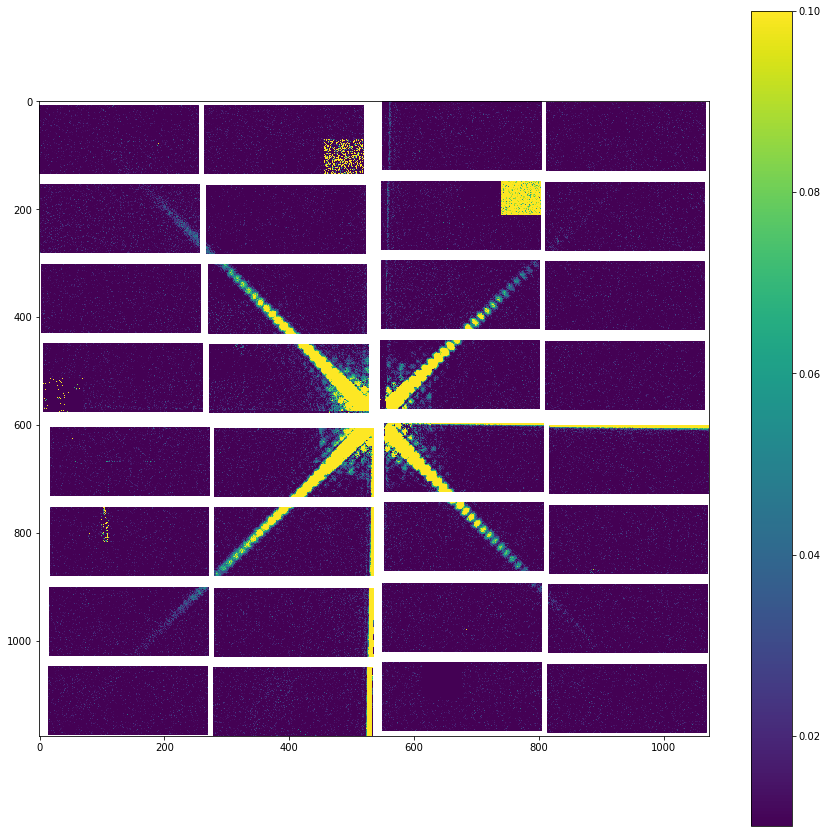

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
plt.imshow(image, vmin=0.01, vmax=0.1, aspect=204.0/236.0)
plt.colorbar()